In [133]:
#CONDA ENV base_conda (python 3.9.7)
#Import packages
#---------------------------------------
import sys
import os
import glob
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm


#Import your modules
#---------------------------------------
import te_rna_f as ter
sys.path.insert(1, '/cndd3/dburrows/CODE/admin_tools/')
from admin_tools import admin_functions as adm

# Define paths
#----------------------------------------------------------------------
l_code = '/Users/dominicburrows/Dropbox/PhD/Analysis/my_scripts/GitHub/'
l_data = '/Users/dominicburrows/Dropbox/PhD/analysis/Project/'
l_fig = '/Users/dominicburrows/Dropbox/PhD/figures/'

s_code = '/cndd3/dburrows/CODE/'
s_data = '/cndd3/dburrows/DATA/'
s_fig = '/cndd3/dburrows/FIGS/'

%load_ext autoreload
sys.version


'3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:23:11) \n[GCC 9.4.0]'

# Calculate binned coverage over full-length TEs

In [188]:
%autoreload
TEs = pd.read_csv('/cndd3/dburrows/DATA/annotations/rmsk/rmsk.hg38.filt-5ptrim.merge.rerr.bed',sep='\t',
                  names=['chr','start','end','TEtype','TEfamily','strand','TEclass','length','TSS_start','TSS_end'])

In [189]:
#Filter for most highly expressed families
df = pd.read_csv('/cndd/dburrows/DATA/te/rna/PE.counts/DE/ATEM_CPM.csv', index_col=0)
ind = np.mean(df[df.index.str.contains('L1')], axis=1) > 1 #indeces of ones to keep
l1_keep = df[df.index.str.contains('L1')][ind].index.values

#higher threshold for Alu
ind = np.mean(df[df.index.str.contains('Alu')], axis=1) > 300
sine_keep = list(df[df.index.str.contains('Alu')][ind].index.values)
sine_keep = list(np.append(sine_keep,  df[df.index.str.contains('SVA')] [np.mean(df[df.index.str.contains('SVA')], axis=1) > 1 ].index.values ))
l1_keep, sine_keep

(array(['L1PA6', 'L1PA4', 'L1PA7', 'L1PA2', 'L1PA5', 'L1PA8A', 'L1PA8',
        'L1PA10', 'L1PA3', 'L1HS'], dtype=object),
 ['AluJo',
  'AluJr',
  'AluSx',
  'AluSz',
  'AluY',
  'AluJb',
  'AluSx1',
  'SVA_D',
  'SVA_F',
  'SVA_B',
  'SVA_E',
  'SVA_C',
  'SVA_A'])

In [192]:
L1 = TEs.loc[TEs['TEfamily'].isin(l1_keep) & (TEs['chr']!='chrY') & (~TEs['chr'].str.contains('_'))].reset_index()
SINE = TEs.loc[TEs['TEfamily'].isin(sine_keep) & (TEs['chr']!='chrY') & (~TEs['chr'].str.contains('_'))].reset_index()

L1_bin = ter.bin_bed(L1, binsize=1000, upstream=20000, downstream=20000)
L1_bin = L1_bin.sort_values(['chr', 'start'])
L1_bin.to_csv('/cndd/dburrows/DATA/te/rna/PE.genomic.bins/L1_bins.bed',sep='\t',header=False,index=False)

# SINE_bin = ter.bin_bed(SINE, binsize=100, upstream=8000, downstream=8000)
# SINE_bin = SINE_bin.sort_values(['chr', 'start'])
# SINE_bin.to_csv('/cndd/dburrows/DATA/te/rna/PE.genomic.bins/SINE_bins.bed',sep='\t',header=False,index=False)

In [198]:
%%bash
#sort by chromosome number, not alphabetically
bedtools sort -g /cndd/emukamel/DrachevaLiu_PsychENCODE_SCZ/L1_bins/hg38.chroms -i /cndd/dburrows/DATA/te/rna/PE.genomic.bins/L1_bins.bed > /cndd/dburrows/DATA/te/rna/PE.genomic.bins/L1_bins.sorted.bed
#bedtools sort -g /cndd/emukamel/DrachevaLiu_PsychENCODE_SCZ/L1_bins/hg38.chroms -i /cndd/dburrows/DATA/te/rna/PE.genomic.bins/SINE_bins.bed > /cndd/dburrows/DATA/te/rna/PE.genomic.bins/SINE_bins.sorted.bed


In [200]:
def my_bedcov(samplepath):
  sample=samplepath.split('/')[-1]
  pref = 'L1'
  bam=f'/cndd3/dburrows/DATA/te/rna/PE.bam/{sample}/Aligned.sortedByCoord.out.bam'
  outdir=f'/cndd/dburrows/DATA/te/rna/PE.genomic.bins/{sample}/'

  sense=f'bedtools coverage -sorted -counts -g /cndd/emukamel/DrachevaLiu_PsychENCODE_SCZ/L1_bins/hg38.genome -bed -s -a /cndd/dburrows/DATA/te/rna/PE.genomic.bins/{pref}_bins.sorted.bed -b {bam} > {outdir}{pref}_bins.{sample}.coverage.sense.bed'
  antisense=f'bedtools coverage -sorted -counts -g /cndd/emukamel/DrachevaLiu_PsychENCODE_SCZ/L1_bins/hg38.genome -bed -S -a /cndd/dburrows/DATA/te/rna/PE.genomic.bins/{pref}_bins.sorted.bed -b {bam} > {outdir}{pref}_bins.{sample}.coverage.antisense.bed'

  if os.path.exists(outdir):
    os.system(sense)
    os.system(antisense)
  else:
    os.mkdir(outdir)
    os.system(sense)
    os.system(antisense)
    
  print(f'Done {sample}')
  return 0

In [195]:
sample=samplepath.split('/')[-1]
pref = 'L1'
bam=f'/cndd3/dburrows/DATA/te/rna/PE.bam/{sample}/Aligned.sortedByCoord.out.bam'
outdir=f'/cndd/dburrows/DATA/te/rna/PE.genomic.bins/{sample}/'
sense=f'bedtools coverage -sorted -counts -g /cndd/emukamel/DrachevaLiu_PsychENCODE_SCZ/L1_bins/hg38.genome -bed -s -a /cndd/dburrows/DATA/te/rna/PE.genomic.bins/{pref}_bins.sorted.bed -b {bam} > {outdir}{pref}_bins.{sample}.coverage.sense.bed'
#antisense=f'bedtools coverage -sorted -counts -g /cndd/emukamel/DrachevaLiu_PsychENCODE_SCZ/L1_bins/hg38.genome -bed -S -a /cndd/dburrows/DATA/te/rna/PE.genomic.bins/{pref}_bins.sorted.bed -b {bam} > {outdir}{pref}_bins.{sample}.coverage.antisense.bed'

In [201]:
if os.path.exists(outdir):
    os.system(sense)
    #os.system(antisense)
else:
    os.mkdir(outdir)
    os.system(sense)
    #os.system(antisense)

In [186]:
samples=glob.glob('/cndd3/dburrows/DATA/te/rna/PE.bam/Sample*')
#creat pool of parallel worker processes
with Pool() as p:
  #imap applies function in parallel
  x=list(tqdm(p.imap(my_bedcov, samples),total=len(samples)))

  0%|                                                     | 0/116 [00:04<?, ?it/s]


KeyboardInterrupt: 

# Visualise read coverage over TE

### L1HS

In [384]:
import seaborn as sns
import re
import warnings
warnings.filterwarnings("ignore")

In [391]:
# Add strand info
L1_bins=pd.read_csv('L1_bins.tsv',sep='\t',names=['chr','start','end','L1_id','-','strand'])
L1_bins['TE_id']=L1_bins['L1_id'].str.extract('(chr.*_[0-9]+)_bin[-]*[0-9]+')
L1 = L1_bins.groupby(['TE_id'])['strand'].first().reset_index()

L1_bins['bin']=L1_bins['L1_id'].str.extract(r'.*_bin([-0-9]+)').astype(int)
L1 = L1_bins[L1_bins['bin']==0]
L1['TSS'] = L1['start']
L1.loc[L1['strand']=='-','TSS']=L1.loc[L1['strand']=='-','end']

# Annotate which elements are within a gene body
gencode = pd.read_csv('/cndd2/jchien/iGenome/gencodev37/gencode.v37.annotation.intragenic_proteincoding_linRNA.bed.gz',sep='\t',
                      names=['chr','start','end','gene_id','strand','-','gene_name','gene_type'],
                     index_col='gene_id')
for i in L1.index:
  L1u=L1.loc[i]
  genes=gencode[(gencode['chr']==L1u['chr'])&(gencode['start']<=L1u['TSS'])&(gencode['end']>=L1u['TSS'])&(gencode['strand']==L1u['strand'])]
  L1.loc[i,'ngenes_samestrand']=genes.shape[0]
  genes=gencode[(gencode['chr']==L1u['chr'])&(gencode['start']<=L1u['TSS'])&(gencode['end']>=L1u['TSS'])&(gencode['strand']!=L1u['strand'])]
  L1.loc[i,'ngenes_oppstrand']=genes.shape[0]

In [386]:
samples=glob('L1_bins.Sample*[GLU|GABA].coverage.bed')
dfs=[]
for sample in tqdm(samples):
  df=pd.read_csv(sample,sep='\t',names=['chr','start','end','id','tmp1','tmp2','coverage'])
  df['sample']=sample.split('.')[1].replace('Sample_','')
  df=df.drop(columns=['tmp1','tmp2'])
  df['TE_id']=df['id'].str.extract('(chr.*_[0-9]+)_bin[-]*[0-9]+')
  df['bin']=df['id'].str.extract('chr.*_[0-9]+_bin([-]*[0-9]+)')
  
  samplename=re.match(r'L1_bins\.(Sample_.*)\.coverage\.bed',sample).group(1)
  libsize=pd.read_csv(f'{samplename}.libsize.txt',header=None)
  df['libsize']=libsize.values[0][0]
  dfs.append(df)


100%|██████████| 116/116 [00:26<00:00,  4.42it/s]


In [420]:
df=pd.concat(dfs)
df=df.dropna()
df['bin']=df['bin'].astype(int)

df['CPM']=1e6*df['coverage']/df['libsize']

df=df.merge(L1[['TE_id','strand','ngenes_samestrand','ngenes_oppstrand','TSS']],on='TE_id',how='left')
df['Position rel. L1 TSS (kb)']=df['bin']/1000

In [427]:
df['gene_overlap']=pd.Categorical(['Intergenic']*df.shape[0],categories=['Intergenic','Intron','Antisense','Intron+Antisense'],ordered=True)
df.loc[df['ngenes_samestrand']>0,'gene_overlap']='Intron'
df.loc[df['ngenes_oppstrand']>0,'gene_overlap']='Antisense'
df.loc[(df['ngenes_oppstrand']>0)&(df['ngenes_samestrand']>0),'gene_overlap']='Intron+Antisense'

In [432]:
df['gene_overlap'].value_counts()

Intergenic          881600
Antisense           696000
Intron              324800
Intron+Antisense     46400
Name: gene_overlap, dtype: int64

In [428]:
# Add metadata about samples
meta=pd.read_csv('../PsychENCODE and SCZ sample metadata - PEC_RNAmeta.csv')
meta['sample']=meta['Sample ID'].str.replace('/','-')+'_'+meta['Cell Type']
meta['sample']=meta['sample'].str.replace('174052-1241','1241').str.upper()
assert set(meta['sample'])==set(df['sample'])

meta['sex']=meta['sex'].str.lower()
meta['AGEDAYS'].fillna(0,inplace=True)
meta['age'] = meta['AGEYEARS']+meta['AGEDAYS']/365
meta['age_group'] = pd.cut(meta['age'],bins=[0,2,5,10,20,40,70,80],
                           labels=['Infancy (0-2 yo)','Early childhood (2-5)','Late childhood (5-10)','Adolescence (10-20)','Adulthood (20-40)','Middle age (40-70)','Late adulthood (70-80)'],
                          ordered=True)

# df.merge(meta,on='sample')
df=df.merge(meta[['sample','age_group','sex']],on='sample')

In [429]:
df_epochs=df.sort_values(['age_group']).groupby(['TE_id','Position rel. L1 TSS (kb)','age_group','sex','gene_overlap'])[['CPM']].mean()
df_epochs_mean=df_epochs.groupby(['age_group','sex','gene_overlap','Position rel. L1 TSS (kb)'])[['CPM']].mean()

In [430]:
# Normalize
libsize=df_epochs_mean.unstack('Position rel. L1 TSS (kb)').iloc[:,:40].mean(axis=1)
df_epochs_mean['mRNA coverage (normalized by flank)']=df_epochs_mean['CPM'].div(libsize,axis=0)
# df_epochs_mean=df_epochs_mean.rename(columns={'coverage':'mRNA coverage (normalized by flank)'})

CPU times: user 2.08 s, sys: 205 ms, total: 2.28 s
Wall time: 2.22 s


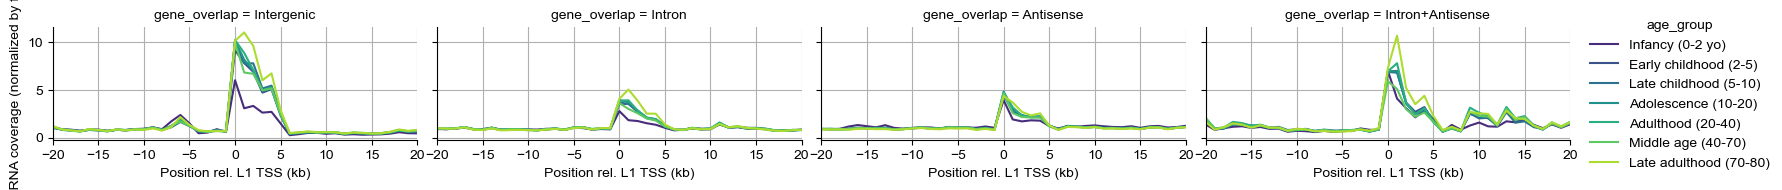

In [431]:
%%time
g=sns.relplot(df_epochs_mean,
              kind='line',
            x='Position rel. L1 TSS (kb)',
              y='mRNA coverage (normalized by flank)',
            hue='age_group',
              col='gene_overlap',
            errorbar=None,
            estimator='median',
            height=2,aspect=2,
              palette='viridis'
           )
for ax in g.axes.flatten():
  ax.grid()
  ax.set_xlim([-20,20])

In [246]:
df_wide=df_epochs_mean.unstack('Position rel. L1 TSS (kb)')

In [247]:
# df_wide_mean=df_wide.groupby('TE_id',axis=0).mean()
# df_wide_mean=df_wide_mean.iloc[df_wide_mean.mean(axis=1).argsort()[::-1]]
df_wide

mRNA coverage (normalized by flank)            \
Position rel. L1 TSS (kb)                                  -50.0     -49.0   
age_group             sex                                                    
Adolescence (10-20)   female                            1.018532  1.064150   
                      male                              1.007589  1.116254   
Adulthood (20-40)     female                            1.018675  1.081746   
                      male                              0.996276  1.143687   
Early childhood (2-5) female                            1.010965  1.146198   
                      male                              0.996697  1.055277   
Infancy (0-2 yo)      female                            1.033343  1.010326   
                      male                              1.070435  1.050905   
Late adulthood(70-80) female                                 NaN       NaN   
                      male                              0.993098  1.165111   
Late childhood (5-10) female                            1.038767  1.159827   
                      male                              0.997641  1.044314   
Middle age (40-70)    female                            0.997712  1.077145   
                      male                              1.020021  1.036051   

                                                                      \
Position rel. L1 TSS (kb)        -48.0     -47.0     -46.0     -45.0   
age_group             sex                                              
Adolescence (10-20)   female  1.293565  1.036770  1.004340  1.049590   
                      male    1.391811  1.079823  1.032563  1.081069   
Adulthood (20-40)     female  1.325460  1.048139  0.997543  1.054377   
                      male    1.415614  1.084062  1.041794  1.091352   
Early childhood (2-5) female  1.422243  1.090827  1.030252  1.076385   
                      male    1.258074  1.044820  0.999397  1.055810   
Infancy (0-2 yo)      female  1.123499  1.014730  0.960637  1.025699   
                      male    1.193783  1.040107  0.995925  1.049537   
Late adulthood(70-80) female       NaN       NaN       NaN       NaN   
                      male    1.533506  1.136223  1.076581  1.118119   
Late childhood (5-10) female  1.473173  1.108271  1.021382  1.038543   
                      male    1.245729  1.026788  1.002435  1.079864   
Middle age (40-70)    female  1.270145  1.005841  0.973736  1.035294   
                      male    1.241142  1.026840  1.013797  1.056348   

                                                                      ...  \
Position rel. L1 TSS (kb)        -44.0     -43.0     -42.0     -41.0  ...   
age_group             sex                                             ...   
Adolescence (10-20)   female  1.070598  1.084194  0.945107  1.118268  ...   
                      male    1.113872  1.078789  0.929576  1.101002  ...   
Adulthood (20-40)     female  1.090785  1.113689  0.939236  1.251254  ...   
                      male    1.128728  1.116850  0.954936  1.156440  ...   
Early childhood (2-5) female  1.122040  1.104750  0.941019  1.176267  ...   
                      male    1.087068  1.082942  0.947130  1.121368  ...   
Infancy (0-2 yo)      female  1.020298  1.133055  0.998444  1.117682  ...   
                      male    1.040456  1.128442  0.968712  1.078730  ...   
Late adulthood(70-80) female       NaN       NaN       NaN       NaN  ...   
                      male    1.182546  1.088602  0.938260  1.164402  ...   
Late childhood (5-10) female  1.131239  1.082867  0.919656  1.129740  ...   
                      male    1.064639  1.100803  0.953769  1.077256  ...   
Middle age (40-70)    female  1.061483  1.075499  0.951179  1.105987  ...   
                      male    1.074174  1.104792  0.953911  1.105067  ...   

                                                                      \
Position rel. L1 TSS (kb)         40.0      41.0      42.0      43.0   
age_group             s

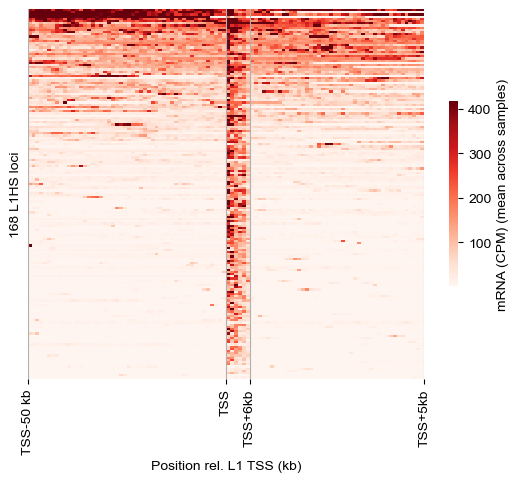

In [172]:
ax=sns.heatmap(df_wide_mean,yticklabels=False,robust=True,cmap='Reds',
               cbar_kws={'shrink':.5,'label':'mRNA (CPM) (mean across samples)'}
              )
ax.set_ylabel(f'{df_wide_mean.shape[0]} L1HS loci')
ax.set_xticks([0,50,56,100],labels=['TSS-50 kb','TSS','TSS+6kb','TSS+5kb'])
ax.grid(axis='x')
ax.get_figure().savefig('Plots/MeanRNA_CPM_heatmap.pdf')

In [168]:
!mkdir Plots

### Alu

In [ ]:
b


### SVA